Compute the matrix $\eta$ with fixed-point iterations.

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as linalg
import scipy.fft as fft

plt.style.use('default')
plt.rcParams["text.usetex"] = True

In [2]:
n = 50
p = 10
L = 5
z = -1+1j
setting = "$n = {} \quad p = {} \quad L = {} \quad z = {}$".format(n, p, L, z)

In [3]:
eigvals_circ = np.append(2*L-1, [np.sin((2*L-1)*k*np.pi/n)/np.sin(k*np.pi/n) for k in range(1, n)])

In [4]:
def fixed_point_step_matrix(etam, kind):
    etap = np.zeros((n, n), dtype='complex')
    for u in range(n):
        for v in range(n):
            if kind == 'toeplitz':
                for k in range(max(0, -L+u+1), min(n-1, L+u-1)+1):
                    Bvk = 1 if np.abs(v-k) < L else 0
                    etap[u, v] += (etam[k%n, v]-Bvk)/(z-1+etam[k%n, k%n])
            elif kind == 'circulant':
                for k in range(-L+u+1, L+u-1+1):
                    Bvk = 1 if np.abs(v-k%n) < L or np.abs(v-k%n) > n-L else 0
                    etap[u, v] += (etam[k%n, v]-Bvk)/(z-1+etam[k%n, k%n])
            else:
                raise NotImplementedError(kind)
            etap[u, v] /= p
    return etap

def eta(eps=1e-5, dt=10, kind='toeplitz'):
    etam = np.zeros((n, n), dtype='complex')
    etap = fixed_point_step_matrix(etam, kind)
    diff = linalg.norm(etap-etam)
    t1 = time.time()
    while diff > eps:
        etap, etam = fixed_point_step_matrix(etap, kind), etap
        diff = linalg.norm(etap-etam)
        t2 = time.time()
        if t2-t1 > dt:
            t1 = t2
            print(diff)
    return etap

In [5]:
def fixed_point_step_diag(eta0m):
    return np.mean(eigvals_circ**2/(eigvals_circ-p*(z-1+eta0m)))

def eta0(eps=1e-5, dt=10):
    eta0p, eta0m = fixed_point_step_diag(0), 0
    diff = np.abs(eta0p-eta0m)
    t1 = time.time()
    while diff > eps:
        eta0p, eta0m = fixed_point_step_diag(eta0p), eta0p
        diff = np.abs(eta0p-eta0m)
        t2 = time.time()
        if t2-t1 > dt:
            t1 = t2
            print(diff)
    return eta0p

In [6]:
mat = eta(kind='circulant')
c = mat[0]
eigvals = fft.fft(c)

In [7]:
c[0] # diagonal element computed with the fixed point equation on the matrix eta

(0.3072764245052474+0.15449199017756j)

In [8]:
eta0() # diagonal element computed with the fixed point equation on eta_0 only

(0.3072762612245661+0.15449182512839674j)

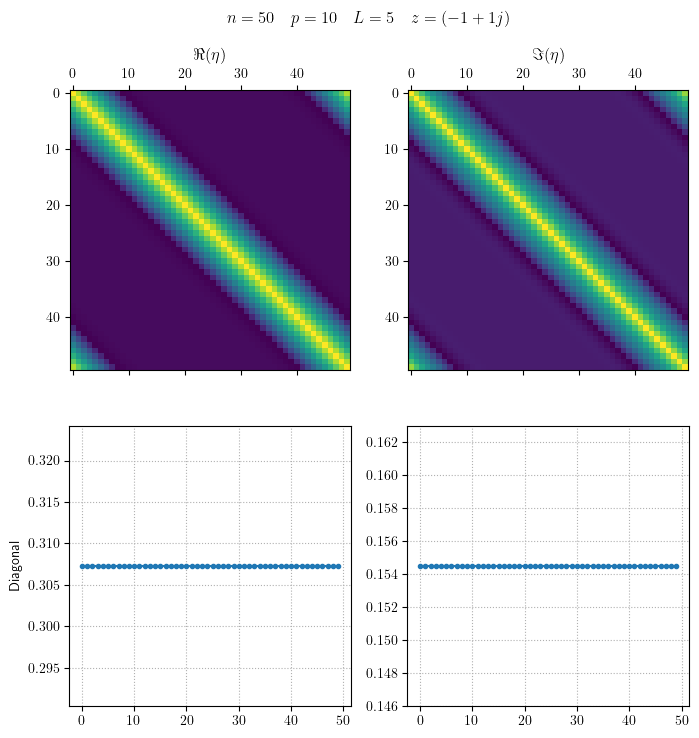

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
ax[0, 0].matshow(mat.real)
ax[0, 0].set_title("$\Re(\eta)$".format(z))
ax[0, 1].matshow(mat.imag)
ax[0, 1].set_title("$\Im(\eta)$".format(z))
ax[1, 0].plot(np.diag(mat.real), marker='.')
ax[1, 0].grid(ls=':')
ax[1, 1].plot(np.diag(mat.imag), marker='.')
ax[1, 1].grid(ls=':')
ax[1, 0].set_ylabel("Diagonal")
fig.suptitle(setting)
plt.show()

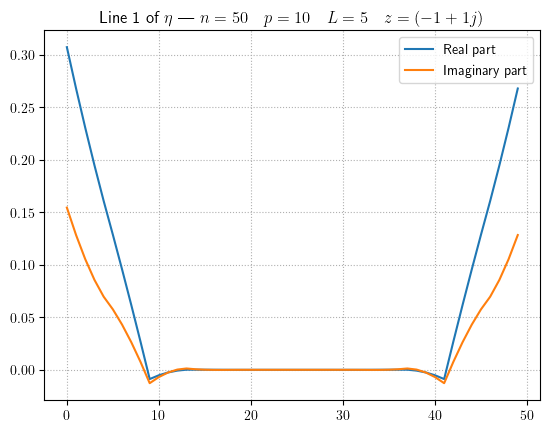

In [10]:
line = n//2-1
line = 0
plt.plot(mat.real[line], label="Real part")
plt.plot(mat.imag[line], label="Imaginary part")
plt.grid(ls=':')
plt.legend()
plt.title("Line {} of $\eta$ | ".format(line+1)+setting)
plt.show()

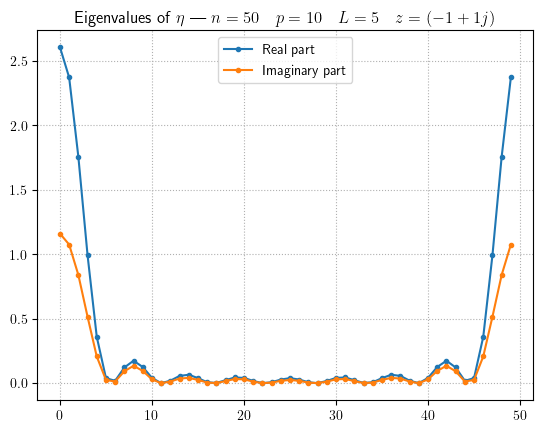

In [11]:
plt.plot(eigvals.real, marker='.', label="Real part")
plt.plot(eigvals.imag, marker='.', label="Imaginary part")
plt.grid(ls=':')
plt.legend()
plt.title("Eigenvalues of $\eta$ | "+setting)
plt.show()

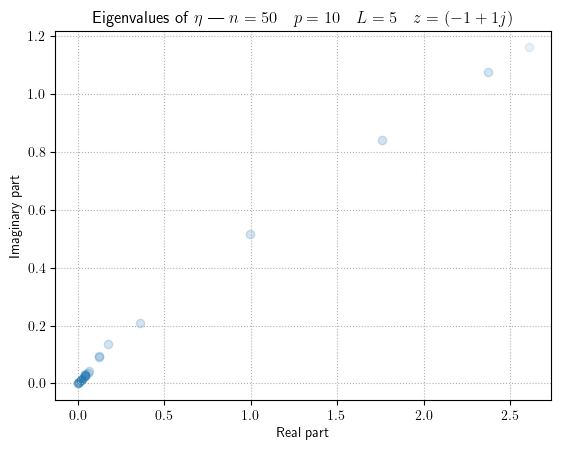

In [12]:
plt.scatter(eigvals.real, eigvals.imag, marker='o', alpha=0.1)
plt.grid(ls=':')
plt.xlabel("Real part")
plt.ylabel("Imaginary part")
plt.title("Eigenvalues of $\eta$ | "+setting)
plt.show()